# Projet Python M2 IMSD

Description du projet :
Analyse des matches de ligue 1 depuis la saison 2003/2004. Le but est d'en apprendre plus sur les cotes fixées par les bookmakers. Sont-elles correctes ? Est ce possible de prédire les matches de ligue 1 ?
Si les résultats de ce projet son concluant, il pourrait être intéressant de mettre en place des indicateurs afin d'aider les parieurs et éventuellement s'étendre à d'autres ligues

## 1. Pre-processing des données

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import wilcoxon, pearsonr, spearmanr, poisson
import os 
import sys
%matplotlib inline
plt.style.use('seaborn-whitegrid') # theme
plt.rcParams['figure.figsize'] = (11,7) # taille des figures

In [42]:
package_dir = os.path.dirname(os.path.abspath(sys.argv[1]))
#file_name  = datetime.datetime(2018, 6, 1).strftime("%B")
file_name = "exctract"
thefile = os.path.join(package_dir, file_name+'.csv')
print(thefile)
extract = pd.read_csv(thefile)
#extract = pd.read_csv("C:/Users/Daniel/Desktop/M2 IMSD/Cours/Python IMSD/Projet_python/football-ligue-1-scr#aping-eda-master/extract.csv")

/home/sam/Documents/cours/python/football-ligue-1-scraping-eda-master/exctract.csv


In [43]:
print(extract.shape)
extract.head()

(5956, 15)


,bmkr_loss,date,day,hours,odds_a,odds_b,odds_draw,outcome_effectif,outcome_odds,prediction_odds,score_a,score_b,season,team_a,team_b
0,0,2019-10-27 20:00:00,Sunday,20:00,1.20,13.07,7.39,HOME,DRAW,1,4,0,2019/2020,Paris SG,Marseille
1,0,2019-10-27 16:00:00,Sunday,16:00,2.28,3.39,3.21,DRAW,AWAY,0,2,2,2019/2020,St Etienne,Amiens
2,0,2019-10-27 14:00:00,Sunday,14:00,1.85,4.46,3.57,HOME,AWAY,1,3,2,2019/2020,Rennes,Toulouse
3,0,2019-10-26 19:00:00,Saturday,19:00,2.36,3.19,3.27,HOME,DRAW,1,2,0,2019/2020,Brest,Dijon
4,0,2019-10-26 19:00:00,Saturday,19:00,1.43,7.80,4.52,HOME,AWAY,1,2,0,2019/2020,Lyon,Metz


In [4]:
# On vérifie que la base ne contient pas de valeurs manquantes :
extract.isnull().sum()

bmkr_loss           0
date                0
day                 0
hours               0
odds_a              0
odds_b              0
odds_draw           0
outcome_effectif    0
outcome_odds        0
prediction_odds     0
score_a             0
score_b             0
season              0
team_a              0
team_b              0
dtype: int64

In [5]:
extract.dtypes

bmkr_loss             int64
date                 object
day                  object
hours                object
odds_a              float64
odds_b              float64
odds_draw           float64
outcome_effectif     object
outcome_odds         object
prediction_odds       int64
score_a               int64
score_b               int64
season               object
team_a               object
team_b               object
dtype: object

On retire la saison 2003/2004 car les données la concernant sont incomplètes. On retire également la saison 2019/2020 car elle est encore en cours. On change ensuite le contenu de la variable *season* afin de garder seulement la première année. Par exemple, dans ce qui suit, la saison 2015/2016 sera simplement appelée saison 2015.

In [6]:
df = extract[(extract.season != "2019/2020") & (extract.season != "2003/2004")]
df.shape

(5696, 15)

In [7]:
df['season'] = df['season'].str[:4]

/home/sam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Créer un dicitonnaire avec la saison en clé et un dataframe avec toutes les données correspondantes en valeur :

In [8]:
values=[]
for season, df_season in df.groupby('season'):
    values.append(df_season)

mydict = dict(list(enumerate(values)))

for i in range(0,15) :
    mydict[list(reversed(df['season'].unique()))[i]] = mydict.pop(i)
    
mydict.keys()

dict_keys(['2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018'])

Une saison est censée comporter, au plus, 380 matches (38 journées de 10 matches). Certaines saisons peuvent comporter moins de matches du fait des forfaits ou des annulations de scores prononcés par la Ligue de Football Professionnel. Aussi, depuis 2016, des barrages de relégation ont été instaurés afin de déterminer si le club classé 18ème descend en division inférieure. Cela explique les matches supplémentaires à partir de la saison 2016. En plus d'opposer des équipes de Ligue 1 à des clubs de Ligue 2, ces confrontations représentent un enjeu tel que nous avons décidé de les exclure de la base.

In [9]:
df.groupby("season").count()

,bmkr_loss,date,day,hours,odds_a,odds_b,odds_draw,outcome_effectif,outcome_odds,prediction_odds,score_a,score_b,team_a,team_b
season,,,,,,,,,,,,,,
2004,377,377,377,377,377,377,377,377,377,377,377,377,377,377
2005,379,379,379,379,379,379,379,379,379,379,379,379,379,379
2006,378,378,378,378,378,378,378,378,378,378,378,378,378,378
2007,380,380,380,380,380,380,380,380,380,380,380,380,380,380
2008,380,380,380,380,380,380,380,380,380,380,380,380,380,380
2009,377,377,377,377,377,377,377,377,377,377,377,377,377,377
2010,380,380,380,380,380,380,380,380,380,380,380,380,380,380
2011,380,380,380,380,380,380,380,380,380,380,380,380,380,380
2012,380,380,380,380,380,380,380,380,380,380,380,380,380,380


In [10]:
mydict["2016"] = mydict["2016"].drop(mydict["2016"].index[[0,1]])
mydict["2017"] = mydict["2017"].drop(mydict["2017"].index[[0,1,2,13]])
mydict["2018"] = mydict["2018"].drop(mydict["2018"].index[[0,1,12,13]])
# Verification de la cohérence :
print(mydict["2016"].shape)
print(mydict["2017"].shape)
print(mydict["2018"].shape)

(379, 15)
(380, 15)
(380, 15)


## 2. Exploration de la base

In [11]:
df_work = pd.concat([mydict[key] for key in mydict.keys()])
print(df_work.shape)
df_work.head()

(5686, 15)


,bmkr_loss,date,day,hours,odds_a,odds_b,odds_draw,outcome_effectif,outcome_odds,prediction_odds,score_a,score_b,season,team_a,team_b
5429,0,2005-05-28 19:00:00,Saturday,19:00,1.47,5.72,3.76,HOME,AWAY,1,3,1,2004,AC Ajaccio,Sochaux
5430,1,2005-05-28 19:00:00,Saturday,19:00,2.68,2.72,2.69,AWAY,AWAY,0,1,3,2004,Auxerre,Lille
5431,0,2005-05-28 19:00:00,Saturday,19:00,2.37,3.14,2.69,DRAW,AWAY,0,3,3,2004,Bordeaux,Marseille
5432,1,2005-05-28 19:00:00,Saturday,19:00,5.83,1.48,3.68,HOME,HOME,0,3,2,2004,Istres,Caen
5433,0,2005-05-28 19:00:00,Saturday,19:00,1.63,4.99,3.30,HOME,AWAY,1,1,0,2004,Lens,Toulouse


### 2.1. Variables quantitatives

In [12]:
df_work.describe()

,bmkr_loss,odds_a,odds_b,odds_draw,prediction_odds,score_a,score_b
count,5686.000000,5686.000000,5686.000000,5686.000000,5686.000000,5686.000000,5686.000000
mean,0.214914,2.412117,4.422066,3.464342,0.500703,1.405733,1.015652
std,0.410799,1.339326,2.969340,0.952269,0.500043,1.200921,1.056837
min,0.000000,1.040000,1.110000,2.380000,0.000000,0.000000,0.000000
25%,0.000000,1.740000,2.830000,3.040000,0.000000,1.000000,0.000000
50%,0.000000,2.120000,3.675000,3.200000,1.000000,1.000000,1.000000
75%,0.000000,2.610000,5.060000,3.510000,1.000000,2.000000,2.000000
max,1.000000,28.980000,48.260000,18.070000,1.000000,9.000000,9.000000


Commençons par la description des variables quantitatives. L'équipe à domicile inscrit en moyenne plus de buts que l'équipe à l'extérieur. En revanche, les médianes sont égales, ce qui signifie que les deux équipes s'affrontant inscrivent au plus 1 but dans plus de la moitié des matches considérés. Cela confirme l'analyse souvent faite de la Ligue 1, à savoir qu'il s'agit d'un championnat où la rigueur tactique et défensive est plus importante que l'animation offensive. On observe également que la cote de l'équipe évoluant à domicile est en moyenne inférieure à celle de l'équipe jouant à l'extérieur.

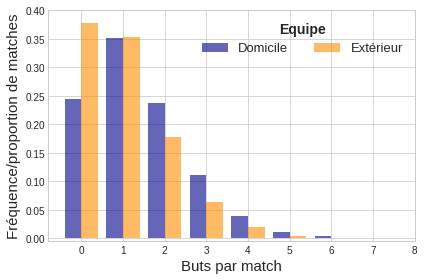

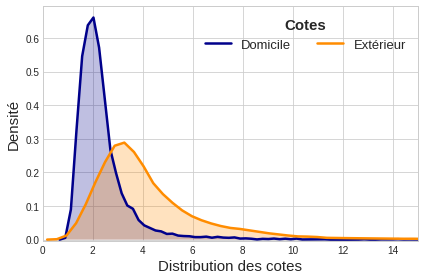

In [13]:
plt.hist(df_work[['score_a', 'score_b']].values, range(9), alpha=0.6, label=['Domicile', 'Extérieur'],
         density=True, color=["darkblue", "darkorange"])
leg=plt.legend(loc='upper right', fontsize=13, ncol=2)
leg.set_title("Equipe", prop = {'size':'14', 'weight':'bold'})
plt.xticks([i-0.5 for i in range(1,10)],[i for i in range(9)])
plt.xlabel("Buts par match",size=15)
plt.ylabel("Fréquence/proportion de matches",size=15)
plt.ylim([-0.005, 0.4])
plt.tight_layout()
plt.show()

sns.distplot(df_work['odds_a'], hist = False, kde_kws = {'shade': True, 'linewidth': 2.5},
            color = 'darkblue', label = 'Domicile')
sns.distplot(df_work['odds_b'], hist = False, kde_kws = {'shade': True, 'linewidth': 2.5},
            color = 'darkorange', label = 'Extérieur')
leg=plt.legend(loc='upper right', fontsize=13, ncol=2)
leg.set_title("Cotes", prop = {'size':'15', 'weight':'bold'})
plt.xlabel("Distribution des cotes",size=15)
plt.ylabel("Densité",size=15)
plt.xlim(0, 15)
plt.ylim([-0.005, None])
plt.tight_layout()
plt.show()

L'analyse graphique montre clairement que les cotes attribuées par les bookmakers ne suivent pas une distribution gaussienne (on pourrait le tester statistiquement mais le skew positif des deux distributions ne laisse aucun doute là-dessus). Ainsi, nous décidons de mettre en place un test non-paramétrique (test de Wilcoxon-Mann-Whitney) afin de tester statistiquement la différence entre les cotes attribuées à l'équipe à domicile et celles attribuées à l'équipe à l'extérieur. Plusieurs versions du test existent selon que l'on considère les échantillons étudiés comme indépendants ou non. Nous devons donc déterminer ce qu'il en est dans notre cas afin de choisir le test le plus approprié.

In [14]:
pearsonr(df_work['odds_a'],df_work['odds_b']) # mesure linéaire de la corrélation

(-0.4706689627281827, 1.828895932252e-311)

In [15]:
spearmanr(df_work['odds_a'],df_work['odds_b']) # mesure non linéaire, plus adaptée au vu du graph

SpearmanrResult(correlation=-0.991905239416012, pvalue=0.0)

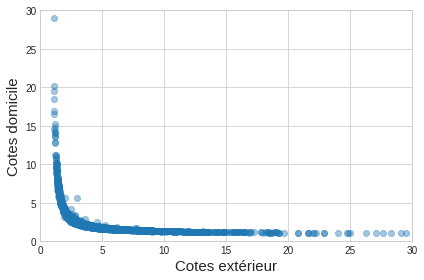

In [16]:
plt.scatter(df_work['odds_b'], df_work['odds_a'], alpha=0.4)
plt.xlabel("Cotes extérieur",size=15)
plt.ylabel("Cotes domicile",size=15)
plt.xlim(0, 30)
plt.ylim([0, 30])
plt.tight_layout()
plt.show()

Comme on pouvait s'y attendre, les cotes de l'équipe à domicile et celle à l'extérieur sont dépendantes : plus la cote d'une équipe est forte, plus celle de son adversaire est faible. Nous mettons donc en place un test des rangs signés de Wilcoxon.

In [17]:
wilcoxon(df_work['odds_a'], df_work['odds_b'])

WilcoxonResult(statistic=2629229.0, pvalue=0.0)

L'hypothèse nulle des tests de Wilcoxon-Mann-Whitney est que les deux échantillons étudiés sont issus de la même distribution. Ici, nous avons $p-value = 0.00$, ce qui nous amène à rejeter l'hypothèse nulle pour tous les niveaux de confiance $\alpha$.

### 2.2. Variables qualitatives

In [18]:
print(df_work['outcome_effectif'].value_counts(normalize = True, sort = False))
print(df_work['outcome_odds'].value_counts(normalize = True, sort = False))
cont_table = pd.crosstab(df_work['outcome_effectif'],df_work['outcome_odds']) # table de contingence
cont_table

AWAY    0.259761
DRAW    0.287900
HOME    0.452339
Name: outcome_effectif, dtype: float64
AWAY    0.657580
DRAW    0.194161
HOME    0.148259
Name: outcome_odds, dtype: float64


outcome_odds,AWAY,DRAW,HOME
outcome_effectif,,,
AWAY,723,321,433
DRAW,1110,308,219
HOME,1906,475,191


Pour ce qui est des variables qualitatives, on remarque que sur la périodé étudiée, l'évènement le plus probable d'après les bookmakers s'est effectivement réalisé dans seulement 50% des cas (afin de simplifier la rédaction et la lecture de la suite du document, nous dirons désormais que les bookmakers se sont trompés en moyenne une fois sur deux). Plus précisément, alors que 28% des matches joués ont débouché sur un match nul, les bookmaker ont attribué la cote la plus élevée à cette issue dans moins de 1% des cas (5 matches). Cette sousestimation s'explique par la tendance des bookmakers à surestimer la probabilité de victoire des équipes évoluant à domicile.

Pour aller plus loin, nous allons tester statistiquement l'existence d'un lien entre les modalités prises par les deux variables de la table de contingence. Autrement dit, nous allons tester l'indépendance entre les deux variables. Pour cela, nous mettons en place un test du $\chi^{2}$ :

In [19]:
freq = np.array([cont_table.iloc[0].values,
                  cont_table.iloc[1].values,
                  cont_table.iloc[2].values])
stats.chi2_contingency(freq)

(403.8140902428699,
 4.170437074797195e-86,
 4,
 array([[ 971.24569117,  286.77594091,  218.97836792],
        [1076.45849455,  317.8417165 ,  242.69978896],
        [1691.29581428,  499.3823426 ,  381.32184312]]))

L'hypothèse nulle d'un test du $\chi^{2}$ est que les lignes et les colonnes de la table de contingence sont indépendantes. Ici, nous avons $p-value = 0.00$, ce qui nous amène à rejeter l'hypothèse nulle pour tous les niveaux de confiance $\alpha$.  Bien que concordant avec nos attentes, nous ne pouvons toutefois pas nous fier pleinement à notre test du fait de la faiblesse de certains des effectifs théoriques utilisés lors du calcul de la statistique de test.

## 3. Analyse des cotes des bookmakers

L'intérêt de cette partie va être d'étudier la justesse des prévisions des bookmarkers. Pour se faire, nous allons simplement calculer les gains obtenus pour une mise de 10€ sur chaque match en se fiant aux prévisions des bookmakers. Nous allons ensuite comparer les gains obtenus avec ceux résultant d'une stratégie qui consisterait à toujours parier sur l'équipe à domicile, toujours parier sur l'équipe à l'extérieur, toujours parier match nul. Nous avons déjà noté que les bookmakers se trompent en moyenne une fois sur deux sur la période considérée, nous pourrons également évaluer s'ils tendent à s'améliorer à mesure que les saisons passent et que de nouvelles informations sont disponibles.

Nous commençons donc par créer une nouvelle colonne qui, pour chaque match, nous donne le gain résultant d'une mise de 10€ suivant la stratégie choisie :

In [20]:
# Stratégie : suivre les bookmakers
odds_true = [None]*df_work.shape[0]
for i in range(0,df_work.shape[0]) :
    if df_work['outcome_effectif'].iloc[i] == 'HOME' :
        odds_true[i] = df_work['odds_a'].iloc[i]
    elif df_work['outcome_effectif'].iloc[i] == 'AWAY':
        odds_true[i] = df_work['odds_b'].iloc[i]
    else :
        odds_true[i] = df_work['odds_draw'].iloc[i]   
        
print(odds_true[0:5])

book_strat = [None]*df_work.shape[0]
for i in range(0,df_work.shape[0]) :
    if df_work['prediction_odds'].iloc[i] == 1 :
        book_strat[i] = 10*(odds_true[i]-1)
    else :
        book_strat[i] = -10
        
df_work['book_strat_gain'] = book_strat

[1.47, 2.72, 2.69, 5.83, 1.63]


In [21]:
# Stratégie : toujours parier sur l'équipe à domicile
dom_strat = [None]*df_work.shape[0]
for i in range(0,df_work.shape[0]) :
    if df_work['outcome_effectif'].iloc[i] == 'HOME' :
        dom_strat[i] = 10*(df_work['odds_a'].iloc[i]-1)
    else :
        dom_strat[i] = -10
df_work['dom_strat_gain'] = dom_strat

    
# Stratégie : toujours parier sur l'équipe à l'extérieur
ext_strat = [None]*df_work.shape[0]
for i in range(0,df_work.shape[0]) :
    if df_work['outcome_effectif'].iloc[i] == 'AWAY' :
        ext_strat[i] = 10*(df_work['odds_b'].iloc[i]-1)
    else : 
        ext_strat[i] = -10
df_work['ext_strat_gain'] = ext_strat
    
# Stratégie : toujours parier sur le match nul
draw_strat = [None]*df_work.shape[0]
for i in range(0,df_work.shape[0]) :
    if df_work['outcome_effectif'].iloc[i] == 'DRAW' :
        draw_strat[i] = 10*(df_work['odds_draw'].iloc[i]-1)
    else :
        draw_strat[i] = -10
df_work['draw_strat_gain'] = draw_strat

On vérifie la cohérence des manipulations sur les premières observations du dataframe puis on calcule la somme des gains pour chaque stratégie :

In [22]:
df_work.head()

,bmkr_loss,date,day,hours,odds_a,odds_b,odds_draw,outcome_effectif,outcome_odds,prediction_odds,score_a,score_b,season,team_a,team_b,book_strat_gain,dom_strat_gain,ext_strat_gain,draw_strat_gain
5429,0,2005-05-28 19:00:00,Saturday,19:00,1.47,5.72,3.76,HOME,AWAY,1,3,1,2004,AC Ajaccio,Sochaux,4.7,4.7,-10.0,-10.0
5430,1,2005-05-28 19:00:00,Saturday,19:00,2.68,2.72,2.69,AWAY,AWAY,0,1,3,2004,Auxerre,Lille,-10.0,-10.0,17.2,-10.0
5431,0,2005-05-28 19:00:00,Saturday,19:00,2.37,3.14,2.69,DRAW,AWAY,0,3,3,2004,Bordeaux,Marseille,-10.0,-10.0,-10.0,16.9
5432,1,2005-05-28 19:00:00,Saturday,19:00,5.83,1.48,3.68,HOME,HOME,0,3,2,2004,Istres,Caen,-10.0,48.3,-10.0,-10.0
5433,0,2005-05-28 19:00:00,Saturday,19:00,1.63,4.99,3.30,HOME,AWAY,1,1,0,2004,Lens,Toulouse,6.3,6.3,-10.0,-10.0


In [23]:
print("Book strat gain = {}".format(df_work['book_strat_gain'].sum()))
print("Home strat gain = {}".format(df_work['dom_strat_gain'].sum()))
print("Away strat gain = {}".format(df_work['ext_strat_gain'].sum()))
print("Draw strat gain = {}".format(df_work['draw_strat_gain'].sum()))

Book strat gain = -2383.3
Home strat gain = -3104.0
Away strat gain = -7262.1
Draw strat gain = -2653.7000000000003


Peu importe la stratégie choisie, les gains réalisés auraient été négatifs. Ce résultat peut paraitre surprenant au premier abord mais est en fait parfaitement prévisible. En effet, nous avons simulé une mise sur chacun des matches contenus dans la base, y compris ceux à l'issue incertaine. Une règle de base des paris sportifs est de ne pas parier sur l'ensemble des matches mais plutôt de cibler et suivre attentivement les performances d'un nombre très restreint d'équipes. Aussi, contrairement à d'autres championnats nationaux, les résultats de Ligue 1 sont réputés être difficiles à prédire.

Afin d'affiner l'analyse, on peut reconduire la même étude mais au niveau d'un club ou encore en considérant chaque saison séparemment. Nous avons choisi de mettre en oeuvre cette dernière option. On constate que peu importe la saison considérée, les gains sont négatifs dans l'écrasante majorité des cas. A la décharge des bookmakers, on peut noter que la stratégie présentant le moins de volatilité est celle qui consisterait à suivre leurs cotes.

Le gain maximum est obtenu pour la saison 2010/2011 avec la stratégie qui consisterait à toujours miser sur le match nul. C'est la saison où le LOSC est champion avec un total de points considéré comme faible (76 points) et où l'OM et l'OL arrivent respectivement 2e et 3e avec 68 et 64 points (soit très peu de points pour des prétendants au titre). Sur l'ensemble des matches joués cette saison, 35% ont débouché sur un match nul (pour rappel, la moyenne est de 28% sur la période considérée).

In [24]:
# mydict['2010'].outcome_effectif.value_counts(normalize = True, sort = False)

In [25]:
temp = df_work.groupby("season").sum().iloc[:,-4:]
print(temp)
temp.describe() # pas de valeurs aberrantes

        book_strat_gain  dom_strat_gain  ext_strat_gain  draw_strat_gain
season                                                                  
2004             -426.7          -260.2         -1300.1            224.3
2005             -338.4          -439.7          -488.8           -245.9
2006             -209.2            10.4          -714.5           -293.7
2007             -198.8          -355.8          -474.8           -183.1
2008              -73.2          -382.4          -307.2           -235.6
2009             -183.6           -73.0          -106.9           -565.7
2010             -494.4          -506.6          -693.5            530.8
2011              -67.4           -56.6          -620.8           -218.2
2012               36.2          -225.3          -406.4            -37.5
2013              -18.4          -431.3          -352.0            -86.4
2014              173.3            99.7          -287.7           -738.9
2015             -155.9          -330.7          -1

,book_strat_gain,dom_strat_gain,ext_strat_gain,draw_strat_gain
count,15.000000,15.000000,15.000000,15.000000
mean,-158.886667,-206.933333,-484.140000,-176.913333
std,190.947921,214.787206,294.288082,310.519815
min,-494.400000,-506.600000,-1300.100000,-738.900000
25%,-273.800000,-369.100000,-651.700000,-274.700000
50%,-155.900000,-234.700000,-406.400000,-218.200000
75%,-30.400000,-64.800000,-322.750000,-61.950000
max,173.300000,234.100000,-106.900000,530.800000


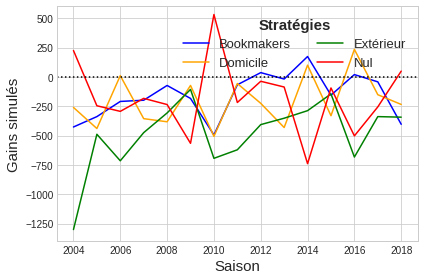

In [26]:
plt.plot(range(2004,2019),temp['book_strat_gain'].values, label = "Bookmakers", color = "blue")
plt.plot(range(2004,2019),temp['dom_strat_gain'].values, label = "Domicile", color = "orange")
plt.plot(range(2004,2019),temp['ext_strat_gain'].values, label = "Extérieur", color = "green")
plt.plot(range(2004,2019),temp['draw_strat_gain'].values, label = "Nul", color = "red")
plt.axhline(y = 0, color = "black", linestyle = ':')
# légende :
leg=plt.legend(loc='upper right', fontsize=13, ncol=2)
leg.set_title("Stratégies", prop = {'size':'15', 'weight':'bold'})
plt.xlabel("Saison",size=15)
plt.ylabel("Gains simulés",size=15)
plt.ylim([-1400, 600])
plt.tight_layout()
plt.show()

## 4. Prediction du score des matches à l'aide de la loi de Poisson

On se focalise d'abord sur une saison, à voir si ça sert vrmt à qqch d'élargir à toutes et refaire 1000 graphs.

In [27]:
mydict['2017'].sort_values('date', inplace = True)

Soit $X$ une variable aléatoire représentant le nombre buts inscrits durant un match de Ligue 1. L'ensemble des valeurs pouvant être prises par $X$ est donc restreint à l'ensemble $\mathbb{N}$ des entiers naturels. Aussi, tous les matchs de Ligue 1 ont une durée identique de 90 minutes. De ce fait, la loi de Poisson est un candidat idéal à la modélisation de $X$. La loi de probabilité d'une variable aléatoire $X$ suivant une loi de Poisson est donnée par : $P(X=x)=\frac{e^{-\lambda}\lambda^{x}}{k!} $. Le paramètre $\lambda$ de la loi est désigné comme étant le nombre moyen d'occurrences pendant l'intervalle de temps considéré ; soit dans notre cas le nombre moyen de buts inscrits par match. En effet, on peut facilement montrer que $\mathbb{E}(X)=\lambda$.

Une fois la loi de probabilité choisie, il nous reste à spécifier ses paramètres. Dans le cas de la loi de Poisson, le seul paramètre à spécifier est $\lambda$. Celui-ci va prendre la valeur moyenne du nombre de buts inscrits par l'équipe à domicile ou l'équipe à l'extérieur. Sur la période étudiée, l'équipe à domicile inscrit en moyenne 1.53 buts tandis que l'équipe à l'extérieur en inscrit 1.19. On remarque également que le nombre maximum de buts inscrits est égal à 8 pour l'équipe à domicile et 5 pour l'équipe à l'extérieur. Une fois le paramètre $\lambda$ obtenu, on peut désormais calculer la probabilité qu'une équipe inscrit un nombre donné de buts selon qu'elle joue à domicile ou à l'extérieur. On modèlise les buts à l'extérieur et à domicile séparemment. Par exemple la probabilité que l'équipe à domicile inscrive 3 buts est égale à 13% ; la probabilité de cet évènement est de 9% pour une équipe à l'extérieur :

In [28]:
print(poisson.pmf(3, mydict['2017'].mean()[4]))
print(poisson.pmf(3, mydict['2017'].mean()[5]))
print(sum(poisson.pmf(i, mydict['2017'].mean()[4]) for i in range(0,9)))
print(sum(poisson.pmf(i, mydict['2017'].mean()[5]) for i in range(0,6)))

0.015625459282705697
0.12912577814673956
0.9999999928626109
0.9951212959181591


On peut recalculer cette probabilité pour n'importe quel $x \in \mathbb{N}$, puis comparer les probabilités obtenues à l'aide la loi de Poisson avec les fréquences effectivement observées :

In [29]:
poisson_proba = np.column_stack([[poisson.pmf(i, mydict['2017'].mean()[j]) for i in range(9)] for j in [4,5]]) # prends 2 numpy object et les met en colonnes
poisson_proba

array([[5.79994393e-01, 2.16763720e-01],
       [3.15944314e-01, 3.31420319e-01],
       [8.60532540e-02, 2.53362112e-01],
       [1.56254593e-02, 1.29125778e-01],
       [2.12794084e-03, 4.93566297e-02],
       [2.31833554e-04, 1.50927378e-02],
       [2.10480464e-05, 3.84600029e-03],
       [1.63794947e-06, 8.40047432e-04],
       [1.11531428e-07, 1.60548539e-04]])

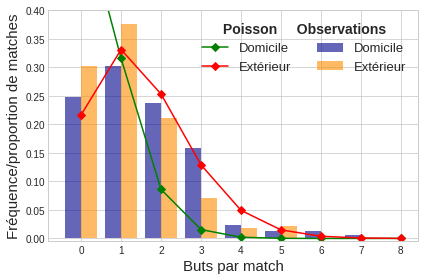

In [30]:
# histogramme des buts marqués :
plt.hist(mydict['2017'][['score_a', 'score_b']].values, range(9), alpha=0.6, label=['Domicile', 'Extérieur'],
         density=True, color=["darkblue", "darkorange"])
# ajouter les lignes pour les probabilités des lois de Poisson :
poisson_dom, = plt.plot([i-0.5 for i in range(1,10)], poisson_proba[:,0],
                  linestyle='-', marker='D',label="Domicile", color = 'green')
poisson_ext, = plt.plot([i-0.5 for i in range(1,10)], poisson_proba[:,1],
                  linestyle='-', marker='D',label="Extérieur", color = 'red')
# légende :
leg=plt.legend(loc='upper right', fontsize=13, ncol=2)
leg.set_title("Poisson     Observations", prop = {'size':'14', 'weight':'bold'})
plt.xticks([i-0.5 for i in range(1,10)],[i for i in range(9)])
plt.xlabel("Buts par match",size=15)
plt.ylabel("Fréquence/proportion de matches",size=15)
plt.ylim([-0.005, 0.4])
plt.tight_layout()
plt.show()

Le graphique se lit comme suit : on observe que l'équipe à domicile inscrit excatement un but dans près de 25% des matches, et que l'équipe à l'extérieur inscrit excatement un but dans près de 30% des matches. Ces fréquences observées sont ensuite à comparer avec les probabilités issues des lois de Poisson. D'après les lois de Poisson utilisées, la probabilité que l'équipe à domicile inscrive exactement un but est d'environ 22%, et d'environ 30% pour l'équipe à l'extérieur. On voit donc que les probabilités générées avec la loi de Poisson suivent assez fidèlement les fréquences observées. Notamment, le croisement entre les deux courbes se fait bien entre 1 et 2 buts.

La loi de Poisson semble adaptée à la modélisation du nombre de buts par match, donc à la modélisation du score d'un match et finalement à la prédiction de l'issue d'un match. C'est ce que nous allons maintenant étudier. Une première option consisterait à ré-effectuer les calculs ci-dessus mais pour chaque équipe selon qu'elle joue à domicile ou à l'extérieur (on aurait donc "deux $\lambda$" par équipe), puis à calculer les probabilités associées à des évènements spécifiques. Par exemple, supposons que l'on cherche à calculer la probabilité que le PSG gagne le prochain classico au Parc de Princes. On note $V$ la variable aléatoire représentant le nombre buts inscrits par le PSG à domicile et W la variable aléatoire représentant le nombre buts inscrits par l'OM à l'extérieur. En supposant que $V$ et $W$ sont indépendantes (et qu'aucune des deux équipes ne peut marquer plus de 8 buts), la probabilité que le PSG gagne est alors donnée par :

$P('Le~PSG~gagne') = P(V = 1) \times P(W=0) + P(V=2) \times P(W=0) + P(V=2) \times P(W=1) + \ldots + P(V=8) \times P(W=7) $

Bien qu'utile, un modèle basé uniquement sur les probabaiblités issues d'une loi de Poisson présente des limites. D'abord, les probabilités associées à la variable aléatoire $V$ seraient les mêmes quel que soit l'adversaire affronté par le PSG. Ainsi, la probabilité que Paris inscrive, par exemple, deux buts sera la même face à l'OM et face à Amiens (tous mes respects au Amiens SC). De plus, une telle modélisation n'intégrant aucune variable explicative, son pouvoir explicatif et prédictif s'en retrouve très amoindri. Pour faire face à ces écueils, nous construisons un modèle de régression de Poisson. Les regressions de Poisson sont un cas particulier des modèles linéaires dit généralisés (GLM). Sans entrer dans les détails, ce type de modélisation permet de traiter les cas ou les caractéristiques de la variable modélisée ne satisfont pas les hypothèses sous-jacentes d'un modèle linéaire classique (variable expliquée continue, normalité des résidus, homoscédasticité etc.). La modélisation du nombre de buts par match correspond typiquement à un des cas où l'utilisation d'un modèle linéaire "classique" n'est pas appropriée.

Nous commençons donc par construire les variables explicatives dont nous allons avoir besoin. Les modèles utilisés en pratique par les bookmakers incluent un grand nombre de variables telles que la forme actuelle de l'équipe, le nombre de blessés, la qualité de l'entraîneur, la qualité de l'effectif etc. Parmi ces variables, la seule que nous pouvons construire est la forme actuelle de l'équipe. Celle-ci va correspondre au nombre de buts inscrits lors des 5 derniers matches.

In [31]:
# Créer un dictionnaire pour les buts inscrits par match pour chaque équipe :
goals = {}
for team in sorted(mydict['2017'].team_a) :    
    goals[team] = None
print(goals.keys())
# Remplit le dicionnaire :
for team in goals.keys() :
    buts = []
    for i in range(0,mydict['2017'].shape[0]) :
        if mydict['2017'].team_a.iloc[i] == team :
            buts.append(mydict['2017'].score_a.iloc[i])
        elif mydict['2017'].team_b.iloc[i] == team :
            buts.append(mydict['2017'].score_b.iloc[i])
        else :
            pass
        goals[team] = buts
# Créer un dictionnaire distinct pour la forme de chaque équipe
forme = {}
for team in sorted(mydict['2017'].team_a) :    
    forme[team] = None
# Remplis le dict en transformant la liste des buts en liste des buts sur les 5 derniers matchs disputés
for team in goals.keys() :
# Pour les 5 premiers matches, nous sommes contraints de calculer la forme comme étant :
    forme[team] = [0,sum(goals[team][0:1]),sum(goals[team][0:2]),sum(goals[team][0:3]),sum(goals[team][0:4])] 
# Pour les autres, on peut la calculer avec une boucle :
    for i in range(5, len(goals[team])) :
        forme[team].append(sum(goals[team][(i-5):i]))

dict_keys(['Amiens', 'Angers', 'Bordeaux', 'Caen', 'Dijon', 'Guingamp', 'Lille', 'Lyon', 'Marseille', 'Metz', 'Monaco', 'Montpellier', 'Nantes', 'Nice', 'Paris SG', 'Rennes', 'St Etienne', 'Strasbourg', 'Toulouse', 'Troyes'])


In [32]:
# On vérifie la cohérence :
np.column_stack([goals['Paris SG'], forme['Paris SG']])

array([[ 2,  0],
       [ 3,  2],
       [ 6,  5],
       [ 3, 11],
       [ 5, 14],
       [ 2, 19],
       [ 0, 19],
       [ 6, 16],
       [ 2, 16],
       [ 2, 15],
       [ 3, 12],
       [ 5, 13],
       [ 4, 18],
       [ 2, 16],
       [ 2, 16],
       [ 1, 16],
       [ 3, 14],
       [ 4, 12],
       [ 3, 12],
       [ 1, 13],
       [ 8, 12],
       [ 1, 19],
       [ 4, 17],
       [ 3, 17],
       [ 1, 17],
       [ 5, 17],
       [ 3, 14],
       [ 2, 16],
       [ 5, 14],
       [ 2, 16],
       [ 2, 17],
       [ 1, 14],
       [ 7, 12],
       [ 1, 17],
       [ 2, 13],
       [ 2, 13],
       [ 0, 13],
       [ 0, 12]])

In [33]:
'''temp_bis['forme'] = [item for sublist in forme.values() for item in sublist]
temp_bis.sort_values(['team_a','team_b'])'''

"temp_bis['forme'] = [item for sublist in forme.values() for item in sublist]\ntemp_bis.sort_values(['team_a','team_b'])"

In [34]:
# On construit le "tableau" qui sera utilisé pour la régression
final = pd.DataFrame()
for team in goals.keys() :
    temp1 = mydict['2017'][(mydict['2017'].team_a == team)][['date','team_a','team_b','score_a']].assign(
        dom = 1).rename(columns={'team_a':'equipe', 'team_b':'adversaire','score_a':'buts'})
    temp2 = mydict['2017'][(mydict['2017'].team_b == team)][['date','team_b','team_a','score_b']].assign(
        dom = 0).rename(columns={'team_b':'equipe', 'team_a':'adversaire','score_b':'buts'})
    temp3 = pd.concat([temp1,temp2])
    temp3.sort_values('date', inplace = True)
    temp3['forme'] = forme[team]
    final = pd.concat([final,temp3])

In [35]:
# On peut mettre en place la régression
modele_poisson = smf.glm(formula = "buts ~ dom + forme + equipe + adversaire", data = final, 
                        family=sm.families.Poisson()).fit()
modele_poisson.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   buts   No. Observations:                  760
Model:                            GLM   Df Residuals:                      719
Model Family:                 Poisson   Df Model:                           40
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1043.4
Date:                Sun, 03 Nov 2019   Deviance:                       742.71
Time:                        22:30:44   Pearson chi2:                     634.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -0.3597      0.234     -1.535      0.125      -0.819       0.100
equipe[T.Angers]              0.1432      0.226      0.634      0.526      -0.299       0.586
equipe[T.Bordeaux]            0.3755      0.215      1.748      0.080      -0.046       0.797
equipe[T.Caen]               -0.3141      0.254     -1.239      0.215      -0.811       0.183
equipe[T.Dijon]               0.4457      0.214      2.081      0.037       0.026       0.865
equipe[T.Guingamp]            0.2860      0.219      1.304      0.192      -0.144       0.716
equipe[T.Lille]               0.1307      0.227      0.576      0.565      -0.314       0.576
equipe[T.Lyon]                0.9025      0.206      4.386      0.000       0.499       1.306
equipe[T.Marseille]           0.8158      0.206      3.965      0.000       0.413       1.219
equipe[T.Metz]               -0.0507      0.238     -0.213      0.831      -0.517       0.415
equipe[T.Monaco]              0.8820      0.207      4.265      0.000       0.477       1.287
equipe[T.Montpellier]        -0.0369      0.234     -0.158      0.875      -0.496       0.422
equipe[T.Nantes]             -0.0283      0.234     -0.121      0.904      -0.487       0.431
equipe[T.Nice]                0.3819      0.215      1.776      0.076      -0.040       0.803
equipe[T.Paris SG]            1.1307      0.214      5.280      0.000       0.711       1.550
equipe[T.Rennes]              0.3145      0.218      1.446      0.148      -0.112       0.741
equipe[T.St Etienne]          0.2542      0.220      1.155      0.248      -0.177       0.686
equipe[T.Strasbourg]          0.2060      0.224      0.922      0.357      -0.232       0.644
equipe[T.Toulouse]            0.0387      0.231      0.167      0.867      -0.414       0.492
equipe[T.Troyes]             -0.1318      0.242     -0.545      0.585      -0.605       0.342
adversaire[T.Angers]          0.2210      0.208      1.064      0.287      -0.186       0.628
adversaire[T.Bordeaux]        0.1584      0.212      0.748      0.455      -0.257       0.574
adversaire[T.Caen]            0.2009      0.208      0.968      0.333      -0.206       0.608
adversaire[T.Dijon]           0.5707      0.194      2.943      0.003       0.191       0.951
adversaire[T.Guingamp]        0.3491      0.202      1.727      0.084      -0.047       0.745
adversaire[T.Lille]           0.4795      0.197      2.430      0.015       0.093       0.866
adversaire[T.Lyon]            0.0796      0.217      0.366      0.714      -0.346       0.506
adversaire[T.Marseille]       0.1584      0.213      0.745      0.456      -0.258       0.575
adversaire[T.Metz]            0.5958      0.193      3.094      0.002       0.218       0.973
adversaire[T.Monaco]          0.1193      0.215      0.555      0.579      

Plusieurs remarques peuvent être faites sur les résultats du modèle. D'abord, notons que parmi les 4 variables explicatives de notre modèle, 2 sont des variables qualitatives (*equipe* et *adversaire*) prenant 38 valeurs différentes. Les inclure dans notre modèle revient en fait à estimer une équation de régression à $1+2+38 \times 2 = 79 $ coefficients (1 pour la constante, les autres pour les variables explicatives), ce qui impacte la qualité de nos estimations au vu de la taille d'échantillon utilisée. Aussi, sachant que la taille de l'échantillon utilisé impacte nécessairement la significativité des coefficients, il est bon de rappeler qu'un coefficient non significatif apporte toujours de l'information quant à la relation étudiée.

Ensuite, avant même de considérer la taille et la significativité des coefficients, il est nécessaire d'expliciter la manière dont deux-ci doivent être lus. Comme nous l'avons dit, la regression de Poisson est un cas particulier des modèles linéaires généralisés. Plus précisément, la fonction de lien utilisée dans le cadre d'une régression de Poisson est la fonction logarithme népérien. Ainsi, afin de pouvoir interpréter les coefficients retournés par le logiciel, il est nécessaire de leur appliquer la fonction exponentiel. Par exemple, le coefficient associé à la variable *forme* est égal à $-0.0074$. Lorsqu'on lui applique la fonction exponentiel on obtient $e^{-0.0074} = 0.992$, ce qui signifie qu'en moyenne, pour une hausse égale à 1 de la valeur prise par *forme*, on s'attend à ce que la valeur prise par la variable *buts* soit **multipliée** par 0.992. Autrement dit, plus la valeur d'un coefficient est proche de 0, plus l'effet de la variable explicative associée à ce coefficient est faible. Dans le cas de la variable *forme*, le coefficient associé est non significativement différent de zéro, il est donc impossible de conclure quant à l'influence de la variable *forme* sur le nombre de buts inscrits. Ce résultat suprenant (on s'attendrait en effet à avoir un impact significativement positif de la forme sur le nombre de buts inscrits) peut s'expliquer par le fait que notre mesure de la forme est une mesure en moyenne, mais aussi par le fait que notre mesure est imparfaite (l'historique des 5 derniers matches disputés est peut-être trop restreint ou trop vaste, la forme est peut-être avant tout capturée par la qualité du jeu *etc*.).

Concernant les autres coefficients de la régression, on voit que la variable *dom* a un impact significativement positif ($e^{0.2487} = 1.3$), ce qui était attendu et corrobore les observations précédemment réalisées. De même, on voit que les coefficients associés à Lyon, Marseille ou le PSG sont positifs pour ce qui est de la variable *equipe* (ces formations marquent en moyenne plus de buts que les autres), mais négatifs (bien que non significatifs) lorsque que l'on considère la variable *adversaire* (il est en moyenne plus difficile de percer les défenses de ces équipes).